In [10]:
%autoreload 2
import sys
sys.path.append('src')
import sqra
import numpy as np
import ajc
import ajcs
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [251]:
plt.set_cmap("bone_r")
plt.set_cmap("afmhot_r")

<Figure size 432x288 with 0 Axes>

In [192]:
class PaperPlots:
    def __init__(self, model):
        self.model = model
        self.Qs = model.Qs
        self.dt = np.array(model.dts)

        self.ajc = ajc.AJCGalerkin(np.dstack(self.Qs), self.dt)
        self.nt = np.size(self.Qs, 0)
        self.nx = np.size(self.Qs[0], 0)
    
    ######

    def jumpactivity(self, p0):
        return self.ajc.geiger(p0)

    def sync(self, p0):
        pp = self.jumpactivity(p0)
        return self.ajc.synchronize(pp)

    def kernelmatrix(self):
        return self.ajc.km

    def koopman_sync(self):
            k = np.zeros((self.nx, self.nx))
            for i in range(self.nx):
                x0 = np.zeros((self.nx, self.nt))
                x0[i,0] = 1
                k[i, :] = self.sync(x0)[:,-1]
            return k

    def koopman_q(self):
        k = np.identity(self.nx)
        for (i,t) in enumerate(self.dt):
            k = k @ expm(t * self.Qs[i])
        return k

    def koopman_error(self):
        ks = self.koopman_sync()
        kq = self.koopman_q()
        return np.linalg.norm(ks-kq, 2)

    #######

    def plot_transkernel(self):
        p = plt.imshow(self.kernelmatrix())

        cb = plt.colorbar()
        cb.set_label("transition probability")
        plt.xticks()
        plt.yticks()
        plt.xlabel("X x T")
        plt.ylabel("X x T")
        return p

    def plot_jumpactivity(self, x0=0):
        p0 = np.zeros((self.nx,self.nt))
        p0[x0,0] = 1

        p = plt.imshow(self.jumpactivity(p0))

        cb = plt.colorbar()
        cb.set_label("jump activity")

        plt.ylabel("X")
        plt.xlabel("t")
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.xticks(np.arange(self.nt+1) -.5, np.hstack([0,np.cumsum(self.dt)]));
        return p

    def plot_sync(self, x0=0, p0=None):
        if p0 is None:
            p0 = np.zeros((self.nx,self.nt))
            p0[x0,0] = 1
        ps = self.sync(p0)

        p = plt.imshow(ps)

        cb = plt.colorbar()
        cb.set_label("probability (synchronized, one state)")

        plt.ylabel("X")
        plt.xlabel("t")
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.xticks(np.arange(self.nt+1) -.5, np.hstack([0,np.cumsum(self.dt)]));
        #plt.clim((0,1))
        return p

    def plot_koopman_sync(self):
        plt.imshow(self.koopman_sync())

        plt.xlabel("X")
        plt.ylabel("X")
        plt.xticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))

        cb = plt.colorbar()
        t2 = sum(self.dt)
        t1 = t2 - self.dt[-1]
        cb.set_label(f"probability (synchronized, t $\in  [{t1},{t2}]  $)")
        #plt.clim((0,1))

    def plot_koopman_q(self):
        plt.imshow(self.koopman_q())
        plt.xlabel("X")
        plt.ylabel("X")

        plt.xticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))

        cb = plt.colorbar()
        t2 = sum(self.dt)
        cb.set_label(f"probability (exact, t={t2})")
        #plt.clim((0,1))

    def plot_all(self, save=False):
        self.plot_transkernel()
        if save:
            plt.savefig(self.model.name() + "_transkernel.pdf")
        plt.show()

        self.plot_jumpactivity(0)
        if save:
            plt.savefig(self.model.name() + "_jumpactivity.pdf")
        plt.show()

        self.plot_sync(0)
        if save:
            plt.savefig(self.model.name() + "_sync.pdf")
        plt.show()

        self.plot_koopman_sync()
        if save:
            plt.savefig(self.model.name() + "_koopman_sync.pdf")
        plt.show()

        self.plot_koopman_q()
        if save:
            plt.savefig(self.model.name() + "_koopman_q.pdf")
        plt.show()


In [193]:
class PaperPlotsSparse(PaperPlots):
    def __init__(self, model):
        self.model = model
        self.Qs = model.Qs
        self.dt = np.array(model.dts)

        self.ajcs = ajcs.AJCS(self.Qs, self.dt)
        self.nt = np.size(self.Qs, 0)
        self.nx = np.size(self.Qs[0], 0)

    def jumpactivity(self, p0):
        return self.ajcs.geiger(p0.T).T

    def sync(self, p0):
        pp = self.jumpactivity(p0)
        return self.ajcs.synchronize(pp)

    def kernelmatrix(self):
        return  self.ajcs.km.toarray()


In [71]:
class DoubleWell:
    def __init__(self, nx = 5, ny = 1, xlims=(-1.5,1.5), ylims=(-1.5,1.5), dt=1, nt=4, beta=1):
        xs = np.linspace(*xlims, nx)
        ys = np.linspace(*ylims, ny)
        self.xs, self.ys = np.meshgrid(xs, ys, sparse=True)
        self.beta = beta

        self.nt = nt
        self.dt = dt
        self.nx = nx * ny
        self._compute()

    def _compute(self):
        self.dts = np.repeat(self.dt, self.nt)
        self.u = self.potential()
        self.sqra = sqra.Sqra(self.u, beta=self.beta)
        # use the commented version for dense computation
        #self.Qs = [self.sqra.Q.toarray()]*len(self.dt)
        self.Qs = [self.sqra.Q]*len(self.dts)
    
    def potential(self):
        return (self.xs**2-1)**2 + self.ys**2

    def name(self):
        return "dw"

In [134]:
class TripleWell(DoubleWell):
    def __init__(self, xlims=(-2, 2), ylims=(-1, 2), **kwargs):
        super().__init__(xlims=xlims, ylims=ylims, **kwargs)

    def potential(self):
        x = self.xs
        y = self.ys
        V = (3/4 * np.exp(-x**2 - (y-1/3)**2)
            - 3/4 * np.exp(-x**2 - (y-5/3)**2)
            - 5/4 * np.exp(-(x-1)**2 - y**2)
            - 5/4 * np.exp(-(x+1)**2 - y**2)
            + 1/20 * x**4 + 1/20 * (y-1/3)**4)
        return V

    def name(self):
        return "tw"

In [174]:
class TripleWellBeta(TripleWell):
    def __init__(self, beta1, beta2, **kwargs):
        self.beta1 = beta1
        self.beta2 = beta2
        
        super().__init__(**kwargs)

        assert self.nt % 2 == 0
        assert self.nt > 1

        
    def _compute(self):
        self.dts = np.repeat(self.dt, self.nt)
        self.u = self.potential()
        self.sqras = [sqra.Sqra(self.u, beta=self.beta1),
                      sqra.Sqra(self.u, beta=self.beta2)]
        # use the commented version for dense computation
        #self.Qs = [self.sqra.Q.toarray()]*len(self.dt)

        h = self.xs[0,1]-self.xs[0,0]
        #assert np.isclose(self.h, self.ys[1,0]-self.ys[0,0])
        nhalf = np.int(np.floor(self.nt/2))
        phi1 = 1 / (h*h*self.beta1)
        phi2 = 1 / (h*h*self.beta2)
        self.Qs = [phi1 * self.sqras[0].Q] * nhalf
        self.Qs = np.append(self.Qs, [phi2 * self.sqras[1].Q] * nhalf)

    def name(self):
        return "twb"


In [231]:
b=TripleWellBeta(10,0.1, nx=8, ny=6, nt=6, dt=0.1)

In [232]:
p0 = np.zeros((b.nx, b.nt))
p0[:,0] = 1

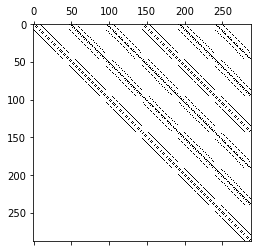

In [233]:
pb = PaperPlotsSparse(b)
plt.spy(pb.kernelmatrix())

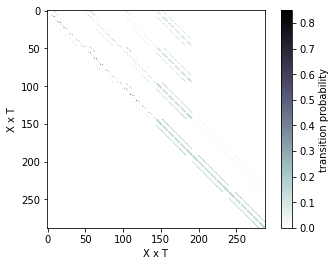

In [234]:
PaperPlotsSparse(b).plot_transkernel()

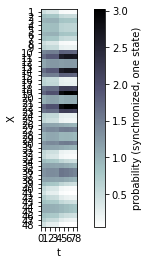

In [207]:
PaperPlotsSparse(b).plot_sync(0, p0)

In [208]:
d = DoubleWell(nx=20)
d = DoubleWell(nx=5, xlims=(-2,2),dt=1, nt=5)
t = TripleWell(nx=10, ny=8, nt=10)

model = t

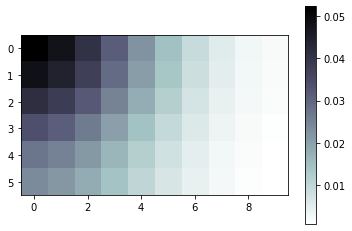

In [128]:
model = TripleWell(nx=10, ny=6, nt=1, dt=6, beta=0.001)
p = PaperPlotsSparse(model)
nx, ny = np.shape(p.model.u)
plt.imshow(np.reshape(p.koopman_q()[0,:], (nx, ny)))
plt.colorbar()

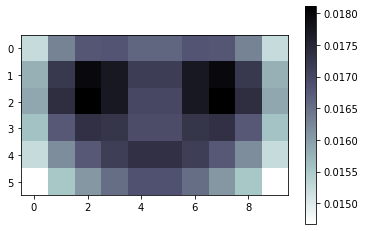

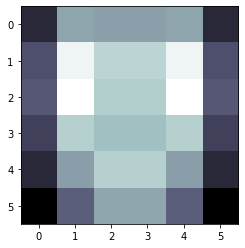

In [83]:
plt.imshow(p.model.u)

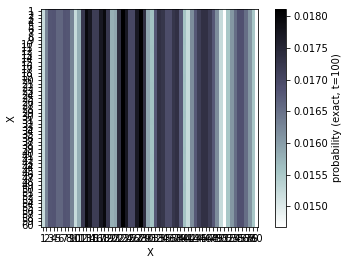

In [89]:

p.plot_koopman_q()

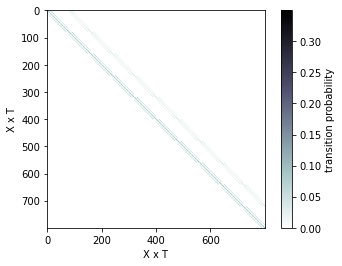

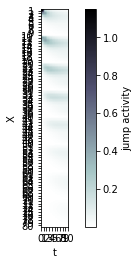

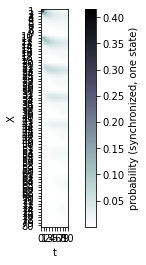

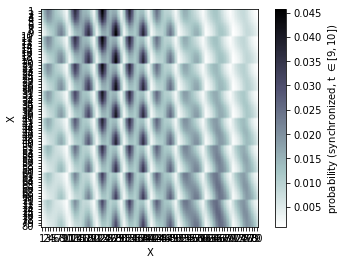

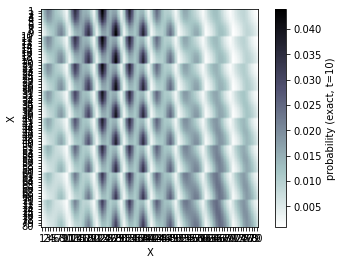

In [63]:
pps = PaperPlotsSparse(model)
pps.plot_all()

In [64]:
class TwoGraph:
    def __init__(self, nt = 2, dt=1):
        q1 = 1
        q0 = 1e-6
        self.Q1 = np.array([[-q1,q1],[q0,-q0]])
        self.Q2 = np.array([[-q0, q0],[q1,-q1]])
        self.nx = 2
        self.nt = nt
        self.Qs = np.zeros((self.nx,self.nx,self.nt))
        
        for i in range(nt):
            self.Qs[:,:,i] = self.Q1 if i/nt < .5 else self.Q2

        self.Qs = [self.Q1 if i/nt < .5 else self.Q2 for i in range(nt)]

        self.dts = [dt]*nt
        #self.dts[0] = 1e-5
        #self.dts[-1] = 1e-5

    def name(self):
        return "twograph"



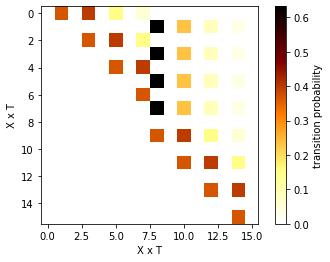

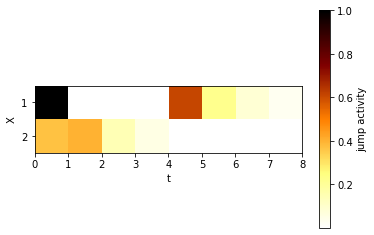

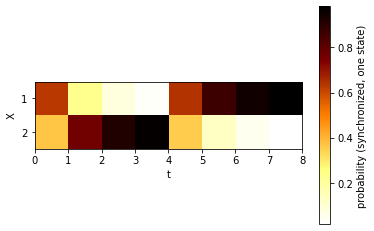

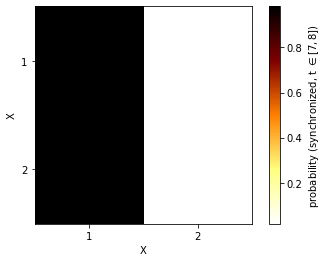

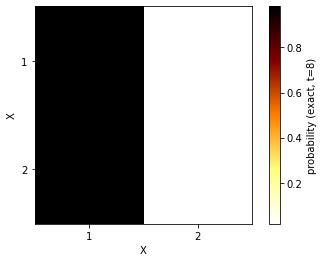

In [252]:
g = TwoGraph(nt=8, dt=1)
PaperPlots(g).plot_all(save=True)

In [242]:
from copy import deepcopy

class ApproximationError:
    def __init__(self, model, nt = 10, tmax = 50):
        self.nts = np.ceil(np.logspace(0, np.log10(tmax), nt, base=10))
        self.nts = self.nts * 2
        self.models = []

        for nt in self.nts:
            m = deepcopy(model)
            m.nt = nt
            m.dt = 1/nt
            m._compute()
            self.models.append(m)
        
        self.errors = [PaperPlotsSparse(m).koopman_error() for m in self.models]
    
    def plot(self):
        nts = self.nts
        errors = self.errors
        plt.yscale("log")
        plt.xscale("log")
        p = plt.plot(1/nts, errors)
        plt.scatter(1/nts, errors)
        plt.xlabel("step-size")
        plt.ylabel("discretization error")
        plt.savefig("dwerror.png")
        return p

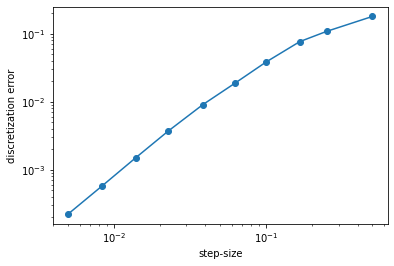

In [246]:
ae = ApproximationError(b, tmax=100, nt=10)
ae.plot()

In [253]:
ae.nts

array([  2.,   4.,   6.,  10.,  16.,  26.,  44.,  72., 120., 200.])

In [15]:
ae2 = ApproximationError(t)

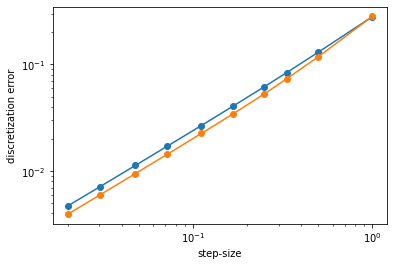

In [16]:
ae.plot()
ae2.plot()